# Compare zonal velocity from ACCESS-OM2-01 with SOSE and ORAS5.

ACESS-OM2-01 simulations stored on the National Computational Infrastructure (NCI) in Canberra, Australia.  
Access to the 1/12 SOSE simulation was provided by Matthew Mazloff, Scripps Institution of Oceanography, UC San Diego.    
ORAS5 1/4 degree simulation available from:  https://www.cen.uni-hamburg.de/icdc/data/ocean/easy-init-ocean/ecmwf-oras5.htmL.  

In [1]:
import xarray as xr
import numpy as np
from glob import glob
import xmitgcm as xgcm
from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cmocean as cmo

import cosima_cookbook as cc

In [2]:
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

In [3]:
from dask.distributed import Client
client = Client()
display(client)

2023-02-07 11:55:22,360 - distributed.diskutils - INFO - Found stale lock file and directory '/home/561/hd4873/parcel_runs/antarctic_connectivity_paper/model_comparison/dask-worker-space/worker-0er4ewto', purging
2023-02-07 11:55:22,420 - distributed.diskutils - INFO - Found stale lock file and directory '/home/561/hd4873/parcel_runs/antarctic_connectivity_paper/model_comparison/dask-worker-space/worker-ftdv7gez', purging
2023-02-07 11:55:22,468 - distributed.diskutils - INFO - Found stale lock file and directory '/home/561/hd4873/parcel_runs/antarctic_connectivity_paper/model_comparison/dask-worker-space/worker-4px2y0p8', purging
2023-02-07 11:55:22,527 - distributed.diskutils - INFO - Found stale lock file and directory '/home/561/hd4873/parcel_runs/antarctic_connectivity_paper/model_comparison/dask-worker-space/worker-zt0ia4va', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 6
Total threads: 18,Total memory: 200.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34919,Workers: 6
Dashboard: /proxy/8787/status,Total threads: 18
Started: Just now,Total memory: 200.00 GiB
Comm: tcp://127.0.0.1:46571,Total threads: 3
Dashboard: /proxy/34897/status,Memory: 33.33 GiB
Nanny: tcp://127.0.0.1:35865,


#### Read in zonal velocity data for figure

In [4]:
%%time
# ACCESS-OM2-01 model RYF simulation, 1/10th deg resolution
data_path = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/'
start_date = '1950-01-01'
end_date = '1970-12-30'
accessfiles = sorted(glob(data_path+'output19*/ocean/ocean.nc')) +\
            sorted(glob(data_path+'output2*/ocean/ocean.nc'))
def preprocess_u(ds):
    ds = ds.sel(yu_ocean=slice(-80,-65)).u
    return ds
access_u = xr.open_mfdataset(accessfiles, preprocess=preprocess_u).sel(time=slice(start_date, end_date)).u.mean(dim='time')

# ACCESS-OM2-01 model IAF simulation, cycle 3, 1/10th deg resolution
session = cc.database.create_session()
expt = '01deg_jra55v140_iaf_cycle3'
start_time = '2005-01-02 00:00:00'
end_time = '2010-12-30 00:00:00'
iaf_access_u = cc.querying.getvar(expt=expt, variable='u', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time=start_time, 
                          end_time=end_time).sel(yu_ocean=slice(-80, -65)).mean(dim='time')

## SOSE, 1/12 deg resolution
sose_data_path_U = '/g/data/e14/hd4873/model_data/sose/so12_i0_year20052010_Uvel_fixed.nc'
sose_U = xr.open_dataset(sose_data_path_U)#.uvel_mean
## resplace ilon and ilat dimensions with lat-lon data rather than using ilon and ilat
sose_U = xr.DataArray(sose_U.uvel_mean.data, coords=[("z", sose_U.depth.data), ("yc", sose_U.lat.data),("xg", sose_U.lon.data), ])
sose_U = sose_U.sel(yc=slice(-82,-59)).load()

CPU times: user 17.5 s, sys: 5.36 s, total: 22.9 s
Wall time: 40.5 s


#### Extract transects from ACCESS-OM2-01 and SOSE.

In [5]:
%%time
trnsct_lon = [45,150,-130,-80]
trnsct_lats = [-69,-71,-76,-75]
trnsct_latn = [-63,-65,-70,-67]

print("First transect")
k = 0
access_ryf_slice1 = access_u.sel(xu_ocean=trnsct_lon[k], method='nearest').sel(yu_ocean=slice(trnsct_lats[k], trnsct_latn[k])).load()
access_iaf_slice1 = iaf_access_u.sel(xu_ocean=trnsct_lon[k], method='nearest').sel(yu_ocean=slice(trnsct_lats[k], trnsct_latn[k])).load()
sose_slice1 = sose_U.sel(xg = trnsct_lon[k], method='nearest').sel(yc=slice(trnsct_lats[k], trnsct_latn[k]))
print("Second transect")
k = 1
access_ryf_slice2 = access_u.sel(xu_ocean=trnsct_lon[k]-360, method='nearest').sel(yu_ocean=slice(trnsct_lats[k], trnsct_latn[k])).load()
access_iaf_slice2 = iaf_access_u.sel(xu_ocean=trnsct_lon[k]-360, method='nearest').sel(yu_ocean=slice(trnsct_lats[k], trnsct_latn[k])).load()
sose_slice2 = sose_U.sel(xg = trnsct_lon[k], method='nearest').sel(yc=slice(trnsct_lats[k], trnsct_latn[k]))
print("Third transect")
k = 2
access_ryf_slice3 = access_u.sel(xu_ocean=trnsct_lon[k], method='nearest').sel(yu_ocean=slice(trnsct_lats[k], trnsct_latn[k])).load()
access_iaf_slice3 = iaf_access_u.sel(xu_ocean=trnsct_lon[k], method='nearest').sel(yu_ocean=slice(trnsct_lats[k], trnsct_latn[k])).load()
# sose longitudes from 0 to 360E, so add 360 to negative lons
sose_slice3 = sose_U.sel(xg = trnsct_lon[k]+360, method='nearest').sel(yc=slice(trnsct_lats[k], trnsct_latn[k]))
print("Fourth transect")
k = 3
access_ryf_slice4 = access_u.sel(xu_ocean=trnsct_lon[k], method='nearest').sel(yu_ocean=slice(trnsct_lats[k], trnsct_latn[k])).load()
access_iaf_slice4 = iaf_access_u.sel(xu_ocean=trnsct_lon[k], method='nearest').sel(yu_ocean=slice(trnsct_lats[k], trnsct_latn[k])).load()
sose_slice4 = sose_U.sel(xg = trnsct_lon[k]+360, method='nearest').sel(yc=slice(trnsct_lats[k], trnsct_latn[k]))

First transect
Second transect
Third transect
Fourth transect
CPU times: user 54 s, sys: 9.85 s, total: 1min 3s
Wall time: 10min 6s


#### Now extract transects from the 5 ORAS5 ensemble members, and take the average of these.

In [6]:
sim = np.arange(0,5,1)
sim_name = ['opa0','opa1','opa2','opa3','opa4']
oras5_data_path = '/scratch/e14/hd4873/oras5/ORCA025/'
# use same period as SOSE simulation
start_time = '2005-01-01'
end_time = '2010-12-30'

# define preprocess functions to limit model domain when reading in
def preprocess_U(ds):
    ds = ds.sel(y=slice(0,200)).vozocrtx
    return ds

# loop through enemble members
for i, s in enumerate(sim):
    print(i,sim_name[i])
    # read in model data 
    oras5_Ufiles = sorted(glob(oras5_data_path+f'vozocrtx/{sim_name[i]}/vozocrtx_*.nc')) 
    
    oras5_U = xr.open_mfdataset(oras5_Ufiles, preprocess=preprocess_U).drop_vars(['nav_lat','nav_lon']).sel(time_counter=slice(start_time, end_time)).chunk({'time_counter':3,}).mean(dim='time_counter')
    oras5_Uref = xr.open_mfdataset(oras5_Ufiles[0:1]).sel(y=slice(0,200)).vozocrtx
    oras5_U = oras5_U['vozocrtx']
    # replace x and y indices with lat and lon data
    latu, lonu = oras5_Uref.nav_lat[:,0].values, oras5_Uref.nav_lon[0,:].values
    oras5_U['x'] = lonu
    oras5_U['y'] = latu
    
    k = 0
    oras5_slice1 = oras5_U.sel(y=slice(trnsct_lats[k], trnsct_latn[k]))[:,:,1329].load() # for 45E
    k = 1
    oras5_slice2  = oras5_U.sel(y=slice(trnsct_lats[k], trnsct_latn[k]+0.2))[:,:,309].load()
    k = 2
    oras5_slice3 = oras5_U.sel(y=slice(trnsct_lats[k], trnsct_latn[k]))[:,:,628].load()
    k = 3
    oras5_slice4 = oras5_U.sel(y=slice(trnsct_lats[k], trnsct_latn[k]))[:,:,828].load()
    
    if i == 0:
        oras5_slice1_ensemble = oras5_slice1.expand_dims(dim={'sim':sim}).copy(deep=True)
        oras5_slice2_ensemble = oras5_slice2.expand_dims(dim={'sim':sim}).copy(deep=True)
        oras5_slice3_ensemble = oras5_slice3.expand_dims(dim={'sim':sim}).copy(deep=True)
        oras5_slice4_ensemble = oras5_slice4.expand_dims(dim={'sim':sim}).copy(deep=True)
    else:
        oras5_slice1_ensemble[i,:,:] = oras5_slice1.values
        oras5_slice2_ensemble[i,:,:] = oras5_slice2.values
        oras5_slice3_ensemble[i,:,:] = oras5_slice3.values
        oras5_slice4_ensemble[i,:,:] = oras5_slice4.values
        
oras5_slice1_ensemble = oras5_slice1_ensemble.mean(dim='sim')
oras5_slice2_ensemble = oras5_slice2_ensemble.mean(dim='sim')
oras5_slice3_ensemble = oras5_slice3_ensemble.mean(dim='sim')
oras5_slice4_ensemble = oras5_slice4_ensemble.mean(dim='sim')

0 opa0
1 opa1
2 opa2
3 opa3
4 opa4


#### Define figure functions.

In [36]:
fontsize = 16
subplot_titles = ['ACCESS-OM2-01 \nRYF years 50-70',
                  'ACCESS-OM2-01 \nIAF 2005-2010',
                  'SOSE-1/12 \n2005-2010',
                  'ORAS5 \n2005-2010']
subplot_labels = ['a)','b)','c)','d)','e)','f)','g)','h)']

## access data required for lat/lon mapping and bathymetry contours
ht = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').ht
ht = ht.sel(yt_ocean = slice(-90,-55))
land_mask = (ht*0).fillna(1)
land_mask_masked = land_mask.where(land_mask == 1)
yt_ocean =ht.yt_ocean.values
yt_ocean[0]=-90
xt_ocean =ht.xt_ocean.values

## sose land mask
sose_land_mask = sose_U[0,:,:].copy()
sose_land_mask = (sose_land_mask*0+1).fillna(0)

# oras5 land mask
oras5_land_mask = oras5_Uref.drop_vars(['nav_lat','nav_lon']).squeeze()[0,:,:].copy()*0
oras5_land_mask = oras5_land_mask.fillna(1)
oras5_land_mask['y'] = latu
oras5_land_mask['x'] = lonu
x =  oras5_land_mask.x.values
x[1149] = 0
new_x = np.sort(np.concatenate((oras5_land_mask.x[429:],oras5_land_mask.x[:429]))) 
oras5_land_mask = xr.concat((oras5_land_mask[:,429:], oras5_land_mask[:,0:429]), dim='x')#.drop_vars(['nav_lat', 'nav_lon'])
oras5_land_mask['x'] = new_x

# define circle 
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""
    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)
cmap_trns = discrete_cmap(20, cmo.cm.balance)

def plot_colorbar(fig,axes_loc,cb_item,label):
    cbaxes = fig.add_axes(axes_loc)
    cbar = plt.colorbar(cb_item, cax = cbaxes, orientation = 'horizontal',extend = 'max', shrink=0.5)
    cbar.set_label(label,fontsize=fontsize,labelpad=2)
    cbar.ax.tick_params(labelsize=14)
    return cbar

fontsize = 16
subplot_titles = ['ACCESS-OM2-01 \nRYF years 50-70',
                  'ACCESS-OM2-01 \nIAF 2005-2010',
                  'SOSE-1/12 \n2005-2010',
                  'ORAS5 \n2005-2010']
subplot_labels = ['a)','b)','c)','d)',]
lvls = np.arange(-0.16, 0.18, 0.02)

def plot_colorbar(fig,axes_loc,cb_item,label):
    cbaxes = fig.add_axes(axes_loc)
    cbar = plt.colorbar(cb_item, cax = cbaxes, orientation = 'horizontal',extend = 'max', shrink=0.5)
    cbar.set_label(label,fontsize=fontsize,labelpad=2)
    cbar.ax.tick_params(labelsize=14)
    return cbar

def figure_spd_transects():
    plt.rcParams['font.size'] = 14
    fig, axes = plt.subplots(nrows=4, ncols=4,figsize=(14,20))
    plt.subplots_adjust(wspace=0.1,hspace=0.2)
    
    # PLOT VERTICAL TRANSECTS
    vmin, vmax = -0.16, 0.16
    # access RYF
    transect_cb = axes[0][0].contourf(access_ryf_slice1.yu_ocean, access_ryf_slice1.st_ocean, access_ryf_slice1, levels=lvls, 
                              cmap=cmo.cm.balance, vmin=vmin, vmax=vmax, extend='both')
    axes[0][0].set_ylim([0,4500])
    axes[0][0].set_xlim([-68,-65.5]) #45/60E
    axes[0][0].invert_yaxis()
    axes[0][0].set_ylabel('Depth (m)', fontsize=15)
    axes[0][1].contourf(access_ryf_slice2.yu_ocean, access_ryf_slice2.st_ocean, access_ryf_slice2, levels=lvls, 
                          cmap=cmo.cm.balance, vmin=vmin, vmax=vmax, extend='both')
    axes[0][1].set_ylim([0,4500])
    axes[0][1].set_xlim([-69,-65])
    axes[0][1].set_xticks([-68,-66])
    axes[0][1].invert_yaxis()
    axes[0][2].contourf(access_ryf_slice3.yu_ocean, access_ryf_slice3.st_ocean, access_ryf_slice3, levels=lvls, 
                              cmap=cmo.cm.balance, vmin=vmin, vmax=vmax, extend='both')
    axes[0][2].set_ylim([0,4500])
    axes[0][2].set_xlim([-75,-71])
    axes[0][2].set_xticks([-75,-73,-71])
    axes[0][2].invert_yaxis()
    axes[0][3].contourf(access_ryf_slice4.yu_ocean, access_ryf_slice4.st_ocean, access_ryf_slice4, levels=lvls, 
                              cmap=cmo.cm.balance, vmin=vmin, vmax=vmax, extend='both')
    axes[0][3].set_ylim([0,4500])
    axes[0][3].set_xlim([-74,-67])
    axes[0][3].set_xticks([-73,-71,-69,-67])
    axes[0][3].invert_yaxis()
    
    # access IAF
    axes[1][0].contourf(access_iaf_slice1.yu_ocean, access_iaf_slice1.st_ocean, access_iaf_slice1, levels=lvls, 
                              cmap=cmo.cm.balance, vmin=vmin, vmax=vmax, extend='both')
    axes[1][0].set_ylim([0,4500])
    axes[1][0].set_xlim([-68,-65.5]) #45/60E
    axes[1][0].invert_yaxis()
    axes[1][0].set_ylabel('Depth (m)', fontsize=15)
    axes[1][1].contourf(access_iaf_slice2.yu_ocean, access_iaf_slice2.st_ocean, access_iaf_slice2, levels=lvls, 
                              cmap=cmo.cm.balance, vmin=vmin, vmax=vmax, extend='both')
    axes[1][1].set_ylim([0,4500])
    axes[1][1].set_xlim([-69,-65])
    axes[1][1].set_xticks([-68,-66])
    axes[1][1].invert_yaxis()
    axes[1][2].contourf(access_iaf_slice3.yu_ocean, access_iaf_slice3.st_ocean, access_iaf_slice3, levels=lvls, 
                              cmap=cmo.cm.balance, vmin=vmin, vmax=vmax, extend='both')
    axes[1][2].set_ylim([0,4500])
    axes[1][2].set_xlim([-75,-71])
    axes[1][2].set_xticks([-75,-73,-71])
    axes[1][2].invert_yaxis()
    axes[1][3].contourf(access_iaf_slice4.yu_ocean, access_iaf_slice4.st_ocean, access_iaf_slice4, levels=lvls, 
                              cmap=cmo.cm.balance, vmin=vmin, vmax=vmax, extend='both')
    axes[1][3].set_ylim([0,4500])
    axes[1][3].set_xlim([-74,-67])
    axes[1][3].set_xticks([-73,-71,-69,-67])
    axes[1][3].invert_yaxis()
    
    # sose
    axes[2][0].contourf(sose_slice1.yc, sose_slice1.z, sose_slice1, levels=lvls, 
                              cmap=cmo.cm.balance, vmin=vmin, vmax=vmax, extend='both')
    axes[2][0].set_ylim([0,4500])
    axes[2][0].set_xlim([-68,-65.5]) #45/60E
    axes[2][0].invert_yaxis()
    axes[2][0].set_ylabel('Depth (m)', fontsize=15)
    axes[2][1].contourf(sose_slice2.yc, sose_slice2.z, sose_slice2, levels=lvls, 
                              cmap=cmo.cm.balance, vmin=vmin, vmax=vmax, extend='both')
    axes[2][1].set_ylim([0,4500])
    axes[2][1].set_xlim([-69,-65])
    axes[2][1].set_xticks([-68,-66])
    axes[2][1].invert_yaxis()
    axes[2][2].contourf(sose_slice3.yc, sose_slice3.z, sose_slice3, levels=lvls, 
                              cmap=cmo.cm.balance, vmin=vmin, vmax=vmax, extend='both')
    axes[2][2].set_ylim([0,4500])
    axes[2][2].set_xlim([-75,-71])
    axes[2][2].set_xticks([-75,-73,-71])
    axes[2][2].invert_yaxis()
    axes[2][3].contourf(sose_slice4.yc, sose_slice4.z, sose_slice4, levels=lvls, 
                              cmap=cmo.cm.balance, vmin=vmin, vmax=vmax, extend='both')
    axes[2][3].set_ylim([0,4500])
    axes[2][3].set_xlim([-74,-67])
    axes[2][3].set_xticks([-73,-71,-69,-67])
    axes[2][3].invert_yaxis()
    
    # oras5
    axes[3][0].contourf(oras5_slice1_ensemble.y, oras5_slice1_ensemble.depthu, oras5_slice1_ensemble, levels=lvls, 
                              cmap=cmo.cm.balance, vmin=vmin, vmax=vmax, extend='both')
    axes[3][0].set_ylim([0,4500])
    axes[3][0].set_xlim([-68,-65.5]) #45/60E
    axes[3][0].invert_yaxis()
    axes[3][0].set_ylabel('Depth (m)', fontsize=15)
    axes[3][1].contourf(oras5_slice2_ensemble.y, oras5_slice2_ensemble.depthu, oras5_slice2_ensemble, levels=lvls, 
                              cmap=cmo.cm.balance, vmin=vmin, vmax=vmax, extend='both')
    axes[3][1].set_ylim([0,4500])
    axes[3][1].set_xlim([-69,-65])
    axes[3][1].set_xticks([-68,-66])
    axes[3][1].invert_yaxis()
    axes[3][2].contourf(oras5_slice3_ensemble.y, oras5_slice3_ensemble.depthu, oras5_slice3_ensemble, levels=lvls, 
                              cmap=cmo.cm.balance, vmin=vmin, vmax=vmax, extend='both')
    axes[3][2].set_ylim([0,4500])
    axes[3][2].set_xlim([-75,-71])
    axes[3][2].set_xticks([-75,-73,-71])
    axes[3][2].invert_yaxis()
    axes[3][3].contourf(oras5_slice4_ensemble.y, oras5_slice4_ensemble.depthu, oras5_slice4_ensemble, levels=lvls, 
                              cmap=cmo.cm.balance, vmin=vmin, vmax=vmax, extend='both')
    axes[3][3].set_ylim([0,4500])
    axes[3][3].set_xlim([-74,-67])
    axes[3][3].set_xticks([-73,-71,-69,-67])
    axes[3][3].invert_yaxis()
    
    transect_labels = ['45\u00b0E','150\u00b0E','130\u00b0W','80\u00b0W']
    for i in range(4):
        for j,ax in enumerate(axes[i]):
            ax.set_title(transect_labels[j])
            ax.set_facecolor('grey')
            ax.text(0.06, 0.1, subplot_titles[i],fontsize=13, c='wheat',ha='left',va='center',transform = ax.transAxes)
            if j == 0:
                ax.text(-0.3, 0.93, subplot_labels[i],fontsize=23, fontweight='bold',transform = ax.transAxes)
            else:
                ax.yaxis.set_ticklabels([])
                
    return fig, axes, transect_cb

### **Figure 2:** Zonal velocity transects

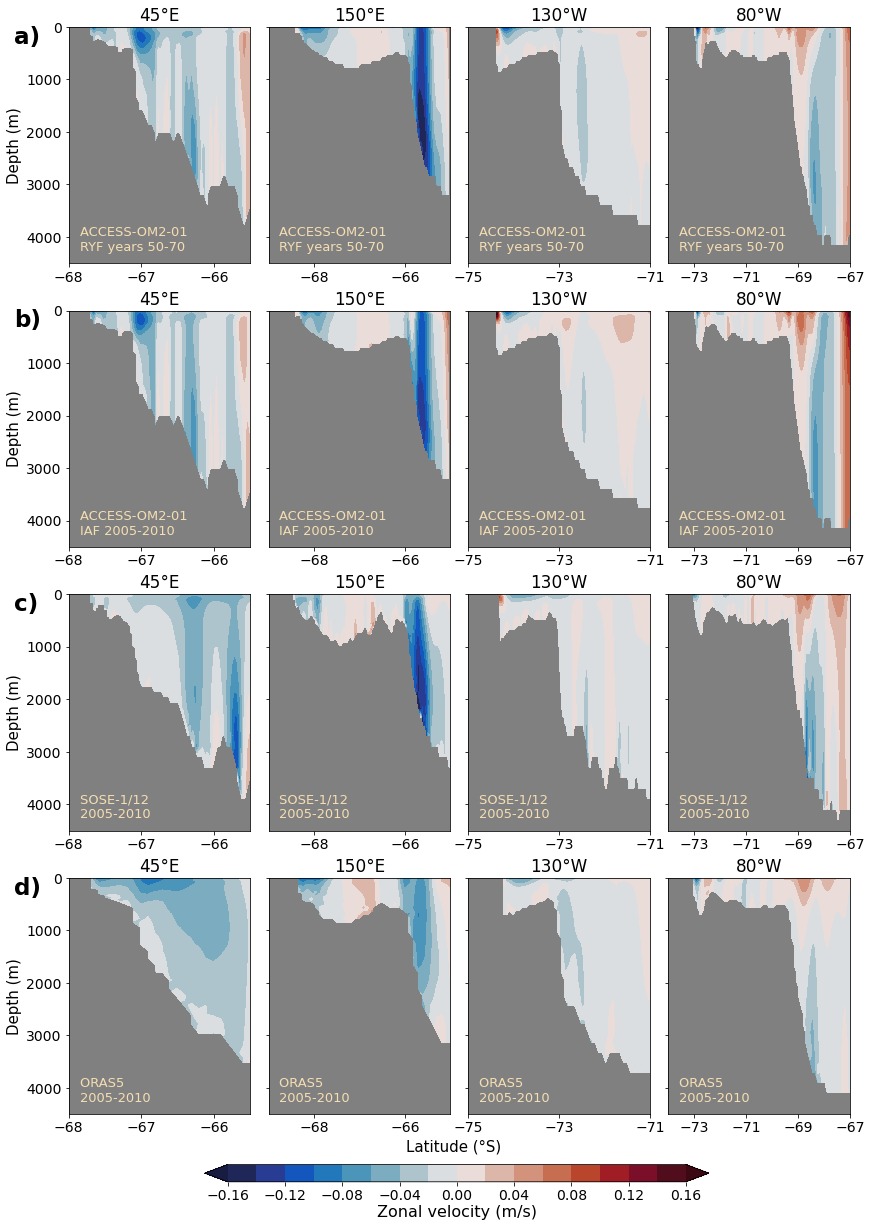

In [42]:
# plot figure
fig, axes, transect_cb = figure_spd_transects()

# plot colorbar
#cbar = plot_colorbar(fig,[0.26, 0.09, 0.5, 0.012],transect_cb,'Zonal velocity (m/s)')
cbar = plot_colorbar(fig,[0.26, 0.078, 0.5, 0.012],transect_cb,'Zonal velocity (m/s)')

axes[3][1].text(0.755, -0.14, 'Latitude (\u00b0S)',fontsize=15, c='k',ha='left',va='center', transform = axes[3][1].transAxes)


plt.show()

# save to file
datadir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/for_publication/'
figfilename = datadir+'Fig02_model_zonal_vel_trnsct_comparison.jpg'
fig.savefig(figfilename, bbox_inches='tight', dpi=300)